In [1]:
from gw_grb_correlation.Fermi.download_data_functions import download_file

In [62]:
# List of detectors you want
detectors = ['n1', 'n2', 'n5']

# Base URL parts
url_tte = "https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2017/bn170817529/current/"
filename_tte = "glg_tte_{}_bn170817529_v00.fit"

# Loop to download each file
for det in detectors:
    url = url_tte + filename_tte.format(det)
    filename = filename_tte.format(det)
    download_file(url, filename)

url_bcat = "https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2017/bn170817529/current/glg_bcat_all_bn170817529_v01.fit"
filename_bcat = "glg_bcat_bn170817529_v00.fit"
download_file(url_bcat, filename_bcat)

1

In [32]:
from astropy.io import fits
import pandas as pd
def extract_tte_data(tte_file):
    
    with fits.open(tte_file) as hdul:
        df = pd.DataFrame(columns=['TIME'])
        df['TIME'] = hdul['EVENTS'].data['TIME']
        return df

def extract_count_rate(df, bins=256):
    
    # Create time bins
    time = df['TIME']
    bin_edges = np.linspace(time.min(), time.max(), bins)
    bin_size = bin_edges[1] - bin_edges[0]
    digitized = np.digitize(time, bin_edges)
    
    # Calculate count rate in each bin
    count_rate = [np.sum(digitized == i) / bin_size for i in range(1, len(bin_edges))]

    return bin_edges[1:], count_rate

def extract_bcat_data(tte_file):
    
    with fits.open(tte_file) as hdul:
        header = hdul['PRIMARY'].header
        return [header['TSTART'], header['TSTOP']]

# Extracting TTE data
tte_data = extract_tte_data(filename_tte)
time, count_rate = extract_count_rate(tte_data)

# Extracting BCAT data
bcat_data = extract_bcat_data(filename_bcat)
print(f"start time: {bcat_data[0]}")
print(f"stop time: {bcat_data[1]}")

start time: 524666461.298598
stop time: 524666482.226598


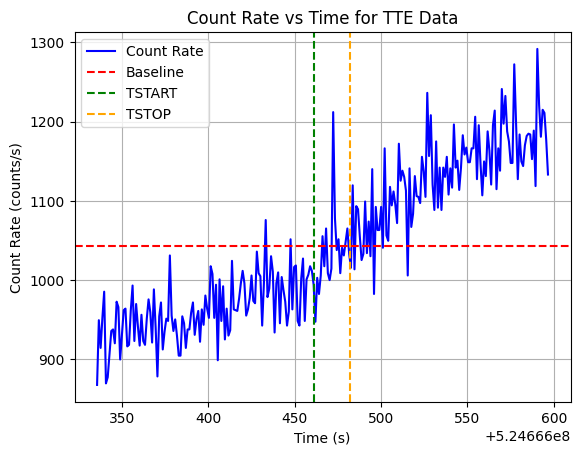

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming time and count_rate are already defined
# Calculate the baseline of the count rate
Baseline = np.average(count_rate)

# Plot the count rate
plt.plot(time, count_rate, label='Count Rate', color='blue')

# Plot the baseline as a horizontal line
plt.axhline(y=Baseline, color='red', linestyle='--', label='Baseline')

# Plot vertical lines for tstart and tstop
tstart, tstop = bcat_data
plt.axvline(x=tstart, color='green', linestyle='--', label='TSTART')
plt.axvline(x=tstop, color='orange', linestyle='--', label='TSTOP')

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Count Rate (counts/s)')
plt.title('Count Rate vs Time for TTE Data')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Ensure inputs are NumPy arrays
time = np.asarray(time)
count_rate = np.asarray(count_rate)

# Mask for the time window
mask = (time >= tstart) & (time <= tstop)
# Time and counts in that window
time_window = time[mask]
counts_window = count_rate[mask]

# Subtract the baseline from the counts
excess_counts = counts_window - Baseline

# Optional: Set any negative values to 0 (if you only want excess above baseline)
excess_counts = np.clip(excess_counts, a_min=0, a_max=None)

# Estimate total excess counts using the trapezoidal rule
# This integrates the rate over time to get counts
total_excess_counts = np.trapz(excess_counts, time_window)

print(f"Total excess counts above baseline in [{tstart}, {tstop}] = {total_excess_counts:.2f}")


Total excess counts above baseline in [524666461.298598, 524666482.226598] = 276.91


In [64]:
def calculate_excess_counts(tstart, tstop, filename, bins =256):
    """
    Calculate the excess counts in the time window [tstart, tstop] above the baseline.
    """

    # Extract TTE data
    with fits.open(filename) as hdul:
        tte_data = pd.DataFrame(columns=['TIME'])
        tte_data['TIME'] = hdul['EVENTS'].data['TIME']
    
    # Create time bins
    time_bin = tte_data['TIME']
    bin_edges = np.linspace(time_bin.min(), time_bin.max(), bins)
    bin_size = bin_edges[1] - bin_edges[0]
    digitized = np.digitize(time_bin, bin_edges)
    time = bin_edges[1:]
    
    # Calculate count rate in each bin
    count_rate = [np.sum(digitized == i) / bin_size for i in range(1, len(bin_edges))]

    # Ensure inputs are NumPy arrays
    time = np.asarray(time)
    count_rate = np.asarray(count_rate)

    # Calculate the baseline of the count rate
    Baseline = np.average(count_rate)

    # Mask for the time window
    mask = (time >= tstart) & (time <= tstop)

    # Time and counts in that window
    time_window = time[mask]
    counts_window = count_rate[mask]

    # Subtract the baseline from the counts
    excess_counts = counts_window - Baseline

    # Estimate total excess counts using the trapezoidal rule
    # This integrates the rate over time to get counts
    total_excess_counts = np.trapz(excess_counts, time_window)

    return total_excess_counts

In [65]:
# Example usage
tstart, tstop = bcat_data   # Use the tstart and tstop from the BCAT data
# Calculate excess counts in the specified time window for each detector
detectors = ['n1', 'n2', 'n5']
for detector in detectors:
    filename = filename_tte.format(detector)
    excess_counts = calculate_excess_counts(tstart, tstop, filename)
    print(f"Total excess counts for {detector} in [{tstart}, {tstop}] = {excess_counts:.2f}")


Total excess counts for n1 in [524666461.298598, 524666482.226598] = -214.30
Total excess counts for n2 in [524666461.298598, 524666482.226598] = -116.54
Total excess counts for n5 in [524666461.298598, 524666482.226598] = -179.47
